In [66]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import xgboost
warnings.filterwarnings('ignore')
np.random.seed(32)
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, make_scorer, recall_score, ConfusionMatrixDisplay, accuracy_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [67]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [68]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [69]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [70]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [71]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [72]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95)),
    ('model', LogisticRegression())
])

In [73]:
def specificity_score(cm):
    tn, fp, fn, tp = cm.ravel() 
    return tn / (tn + fp)

In [74]:
def pipeline_fit(model):
    pipeline.set_params(model=model)
    pipeline.fit(X_train, y_train)

In [75]:
def scores_model(model, threshold=0.5):
    pipeline_fit(model)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_scores = pipeline.predict_proba(X_train)[:, 1]
    y_test_scores = pipeline.predict_proba(X_test)[:, 1] 

    y_train_pred = (y_train_scores >= threshold).astype(int)
    y_test_pred = (y_test_scores >= threshold).astype(int)

    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  
    test_pr_auc = auc(recall_test, precision_test)  
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm_train = confusion_matrix(y_train, y_train_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
    train_specificity = specificity_score(cfm_train)
    test_specificity = specificity_score(cfm)
    
    print("\nModel Performance:")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print(f"Training F2 Score: {train_f2:.4f}")
    print(f"Test F2 Score: {test_f2:.4f}")
    print(f"Training Specificity Score: {train_specificity:.4f}")
    print(f"Test Specificity Score: {test_specificity:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_recall, test_recall, train_f2, test_f2, train_prec, test_prec, train_specificity, test_specificity)

Podstawowy


Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


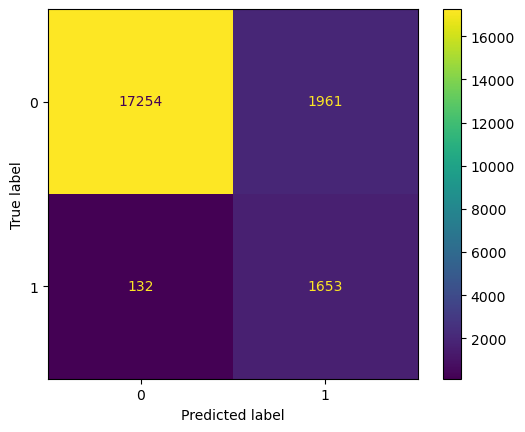

In [99]:
gboost = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced', random_state=32)
g0 = scores_model(gboost)

Najlepsza inwencja twórcza??


Model Performance:
Training Recall Score: 0.9455
Test Recall Score: 0.9339
Training F2 Score: 0.7818
Test F2 Score: 0.7745
Training Specificity Score: 0.8976
Test Specificity Score: 0.8983
Training ROC-AUC: 0.9216
Test ROC-AUC: 0.9161
Training PR-AUC: 0.9000
Test PR-AUC: 0.8948
Training Accuracy Score: 0.9017
Test Accuracy Score: 0.9013
Test Confusion Matrix:
 [[17260  1955]
 [  118  1667]]


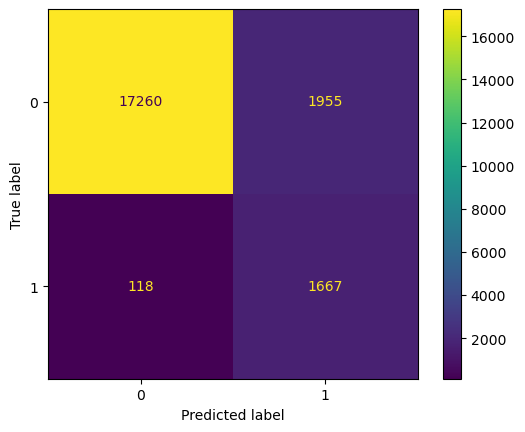

In [100]:
gboost = HistGradientBoostingClassifier(
    learning_rate=0.1,
    class_weight={0: 1, 1: 11.76},
    max_depth=15,
    early_stopping=True,
    min_samples_leaf=7,
    max_leaf_nodes=10,
    max_iter=200,
    random_state=32
)
g1 = scores_model(gboost)

Best parameters: {'min_samples_leaf': 12, 'max_features': 0.8, 'max_depth': 2}

Best model scores:

Model Performance:
Training Recall Score: 0.9407
Test Recall Score: 0.9389
Training F2 Score: 0.7657
Test F2 Score: 0.7649
Training Specificity Score: 0.8883
Test Specificity Score: 0.8887
Training ROC-AUC: 0.9145
Test ROC-AUC: 0.9138
Training PR-AUC: 0.8886
Test PR-AUC: 0.8951
Training Accuracy Score: 0.8928
Test Accuracy Score: 0.8930
Test Confusion Matrix:
 [[17076  2139]
 [  109  1676]]


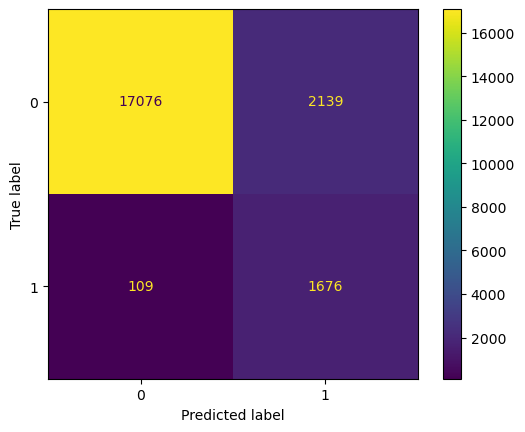

In [101]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0.1, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20)}

scorer = make_scorer(fbeta_score)

random_search_boost = RandomizedSearchCV(estimator=gboost, param_distributions=param_dist, n_iter=50,
                                   cv=5, scoring=scorer, random_state=32)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_

print("\nBest model scores:")
g2 = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight={0: 1, 1: 5}, early_stopping=True, l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_features=0.2, max_iter=200, max_leaf_nodes=31, min_samples_leaf=13; total time=   0.5s
[CV] END class_weight={0: 1, 1: 5}, early_stopping=True, l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_features=0.2, max_iter=200, max_leaf_nodes=31, min_samples_leaf=13; total time=   0.4s
[CV] END class_weight={0: 1, 1: 5}, early_stopping=True, l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_features=0.2, max_iter=200, max_leaf_nodes=31, min_samples_leaf=13; total time=   0.4s
[CV] END class_weight={0: 1, 1: 5}, early_stopping=True, l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_features=0.2, max_iter=200, max_leaf_nodes=31, min_samples_leaf=13; total time=   0.6s
[CV] END class_weight={0: 1, 1: 5}, early_stopping=True, l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_features=0

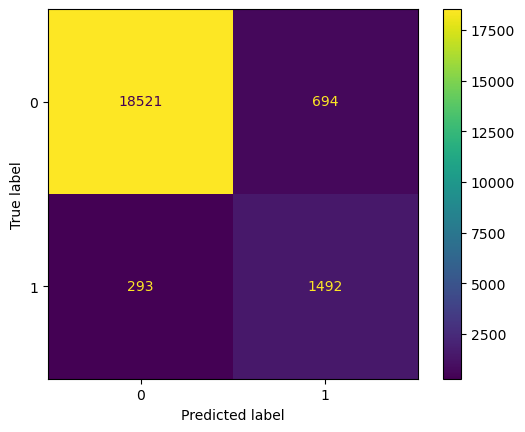

In [79]:
param_dist = {
    'max_depth': range(2, 20),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

# Custom scorer for F2 score
scorer = make_scorer(fbeta_score, beta=2)

# Randomized Search
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,  # Increased from 20 for better exploration
    cv=5,
    scoring=scorer,  # Optimize F2 score
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, mi

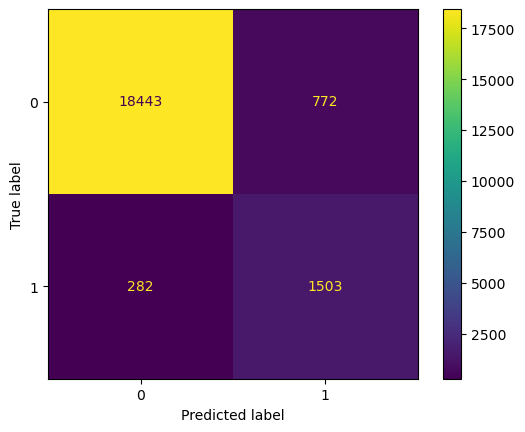

In [94]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score)
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f2_score',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, mi

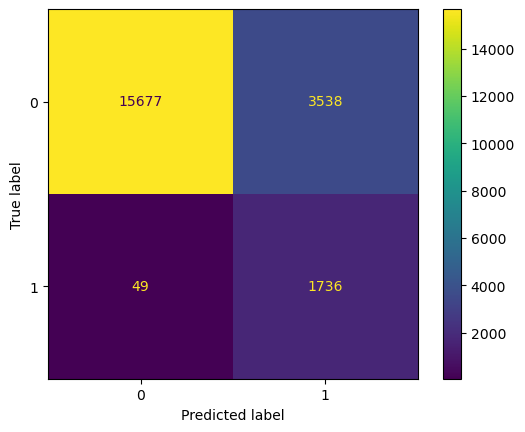

In [81]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score)
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='recall',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, mi

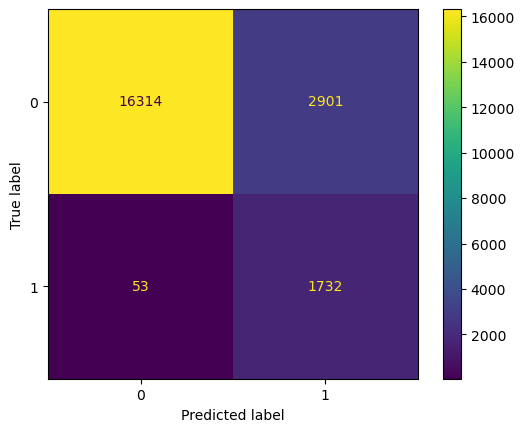

In [82]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score),
   'roc_auc': 'roc_auc'
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='roc_auc',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight=None, early_stopping=True, l2_regularization=0, learning_rate=0.08, max_depth=24, max_features=None, max_iter=200, max_leaf_nodes=31, mi

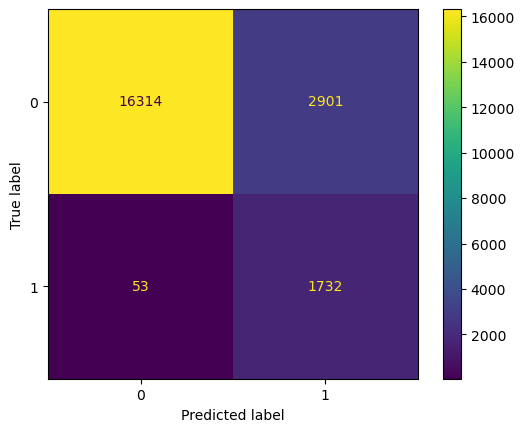

In [83]:
from sklearn.metrics import precision_score

param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score)

}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='roc_auc',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight={0: 1, 1: 20}, early_stopping=True, l2_regularization=1.0, learning_rate=0.05, max_depth=21, max_features=sqrt, max_iter=100, max_leaf_nodes=2, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight={0: 1, 1: 20}, early_stopping=True, l2_regularization=1.0, learning_rate=0.05, max_depth=21, max_features=sqrt, max_iter=100, max_leaf_nodes=2, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight={0: 1, 1: 20}, early_stopping=True, l2_regularization=1.0, learning_rate=0.05, max_depth=21, max_features=sqrt, max_iter=100, max_leaf_nodes=2, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight={0: 1, 1: 20}, early_stopping=True, l2_regularization=1.0, learning_rate=0.05, max_depth=21, max_features=sqrt, max_iter=100, max_leaf_nodes=2, min_samples_leaf=4; total time=   0.0s
[CV] END class_weight={0: 1, 1: 20}, early_stopping=True, l2_regularization=1.0, learning_rate=0.05, max_depth=21, max

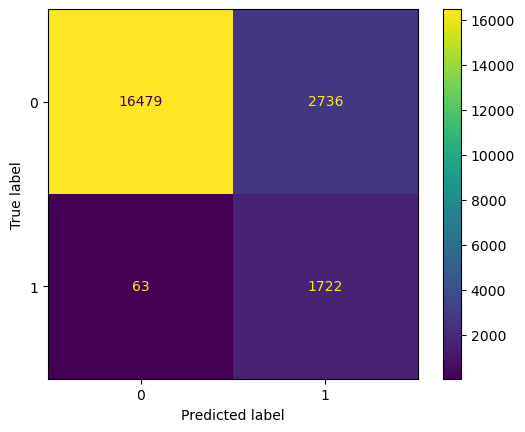

In [84]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.5),
    'recall': make_scorer(recall_score),


}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   1.2s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   1.1s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   1.3s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   1.1s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_dept

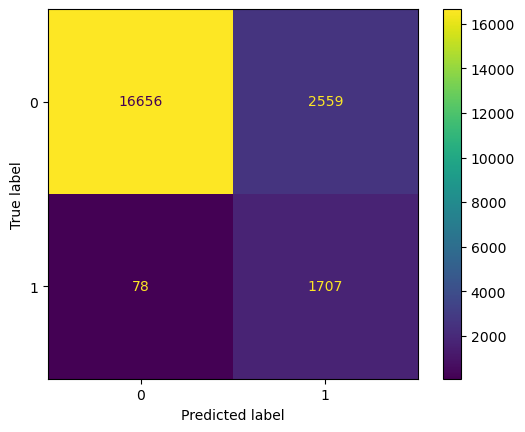

In [85]:
from sklearn.metrics import make_scorer, fbeta_score, recall_score, precision_score, roc_auc_score, f1_score

param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 15),
    'max_iter': [50,100, 200, 250, 300, 400],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.05, 0.1, 0.2, 0.5],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in range(1, 20)] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.4),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

NAJLEPSZY Z RANDOMA

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   3.6s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   3.6s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   4.1s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   2.0s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_dept

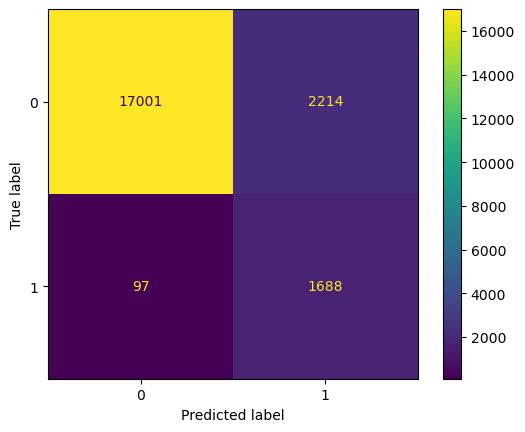

In [ ]:
from sklearn.metrics import make_scorer, fbeta_score, recall_score, precision_score, roc_auc_score, f1_score

param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 15),
    'max_iter': [50,100, 200, 250, 300, 400],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.05, 0.1, 0.2, 0.5],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in range(1, 20)] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.2),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score',  # najlepszy model według F3.2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
g3 = scores_model(boost_best)

PROBOWAŁAM DOSTTROIC TEN WYZEJ ALE NIE WYSZLO LEPIEJ

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   0.9s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   0.8s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   0.8s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_depth=20, max_features=1.0, max_iter=300, max_leaf_nodes=20, min_samples_leaf=12; total time=   0.8s
[CV] END class_weight={0: 1, 1: 11}, early_stopping=False, l2_regularization=0.05, learning_rate=0.2, max_dept

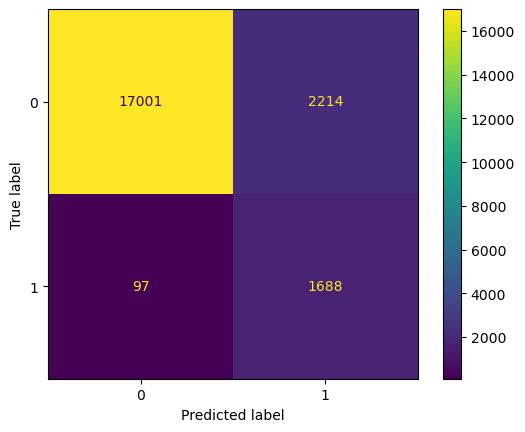

In [87]:
from sklearn.metrics import make_scorer, fbeta_score, recall_score, precision_score, roc_auc_score, f1_score

param_grid = {
    'max_depth': [16, 18, 20],
    'max_features': [0.1, 0.2, 0.3],
    'min_samples_leaf': [5, 6, 7],
    'max_iter': [200, 250, 300],
    'learning_rate': [0.03, 0.05, 0.07,0.1,0.2],
    'l2_regularization': [0.05,0.1, 0.2, 0.3],
    'max_leaf_nodes': [15, 20, 25],
    'class_weight': [{0: 1, 1: w} for w in [14, 15,16, 18]],
    'early_stopping': [False,True]  # Zostawiamy jak było
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.2),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

# RandomizedSearchCV z wieloma scorerami
random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score',  # najlepszy model według F2
    random_state=32,
    n_jobs=1,
    verbose=2
)

# Fit the search
pipeline_fit(random_search_boost)

# Print best parameters
print("Best parameters:", random_search_boost.best_params_)

# Evaluate best model
boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

CAŁKIEM CAŁKIEM


Model Performance:
Training Recall Score: 0.9505
Test Recall Score: 0.9423
Training F2 Score: 0.7718
Test F2 Score: 0.7658
Training Specificity Score: 0.8879
Test Specificity Score: 0.8876
Training ROC-AUC: 0.9192
Test ROC-AUC: 0.9149
Training PR-AUC: 0.8973
Test PR-AUC: 0.8952
Training Accuracy Score: 0.8932
Test Accuracy Score: 0.8922
Test Confusion Matrix:
 [[17055  2160]
 [  103  1682]]


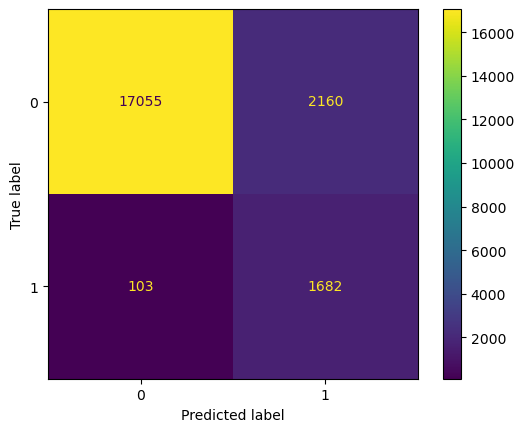

In [113]:
gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=7,
    max_leaf_nodes=10,
    max_iter=300,
    random_state=32,
    l2_regularization=0.1
)
_ = scores_model(gboost)


Model Performance:
Training Recall Score: 0.9517
Test Recall Score: 0.9423
Training F2 Score: 0.7744
Test F2 Score: 0.7666
Training Specificity Score: 0.8891
Test Specificity Score: 0.8882
Training ROC-AUC: 0.9204
Test ROC-AUC: 0.9153
Training PR-AUC: 0.8980
Test PR-AUC: 0.8961
Training Accuracy Score: 0.8944
Test Accuracy Score: 0.8928
Test Confusion Matrix:
 [[17067  2148]
 [  103  1682]]


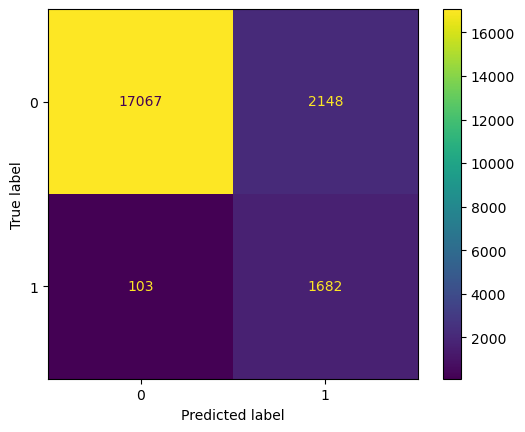

In [114]:
gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=6,
    max_leaf_nodes=10,
    max_iter=500,
    random_state=32,
    l2_regularization=0.1
)
g4 = scores_model(gboost)

najlepszy na razie??

🔍 Najlepszy threshold: 0.53, F2: 0.8580

Model Performance:
Training Recall Score: 0.9462
Test Recall Score: 0.9389
Training F2 Score: 0.7797
Test F2 Score: 0.7746
Training Specificity Score: 0.8958
Test Specificity Score: 0.8958
Training ROC-AUC: 0.9210
Test ROC-AUC: 0.9174
Training PR-AUC: 0.8980
Test PR-AUC: 0.8961
Training Accuracy Score: 0.9001
Test Accuracy Score: 0.8995
Test Confusion Matrix:
 [[17213  2002]
 [  109  1676]]


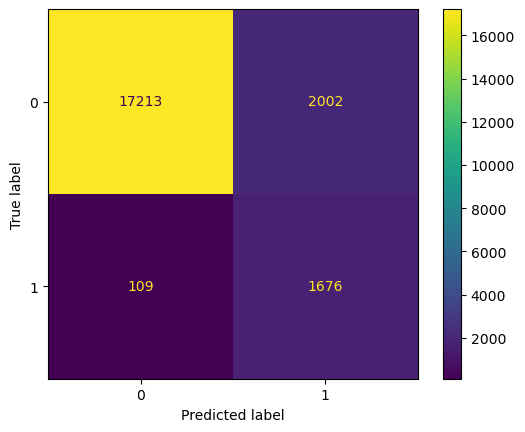

(0.9210293953647032,
 0.9173730694463578,
 0.8979856138312493,
 0.8961292131513019,
 0.946218487394958,
 0.9389355742296919,
 0.7797475367021487,
 0.7746348678129045,
 0.9001224489795918,
 0.8994761904761904,
 0.8958403033344485,
 0.8958105646630237)

In [90]:
y_test_scores = pipeline.predict_proba(X_test)[:, 1]

best_thresh = 0.5
best_f2 = 0
# w ta bete bym dala 3.2 lub 3.3
for t in np.arange(0.1, 0.91, 0.01):
    preds = (y_test_scores >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=3.2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print(f"🔍 Najlepszy threshold: {best_thresh:.2f}, F2: {best_f2:.4f}")
scores_model(gboost, threshold=best_thresh)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................select__k=10; total time=   2.6s
[CV] END .......................................select__k=10; total time=   2.6s
[CV] END .......................................select__k=10; total time=   2.6s
[CV] END .......................................select__k=10; total time=   2.6s
[CV] END .......................................select__k=10; total time=   2.6s
[CV] END .......................................select__k=13; total time=   2.6s
[CV] END .......................................select__k=13; total time=   2.7s
[CV] END .......................................select__k=13; total time=   2.6s
[CV] END .......................................select__k=13; total time=   2.6s
[CV] END .......................................select__k=13; total time=   2.6s
[CV] END .......................................select__k=15; total time=   2.7s
[CV] END .......................................s

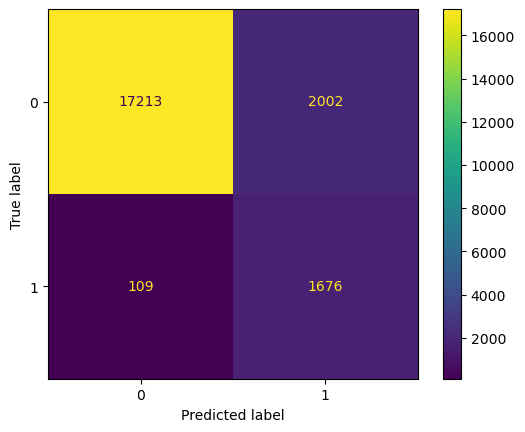

In [92]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

pipe = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif)),
    ('model', gboost)
])

param_grid = {
    'select__k': [10, 13,15,20, 23]  # testujemy ile cech zachować
}

grid = GridSearchCV(
    pipe, 
    param_grid, 
    scoring=make_scorer(fbeta_score, beta=3.2), 
    cv=5, 
    n_jobs=1,
    verbose=2
)
pipeline_fit(grid)
# Wypisanie najlepszej liczby cech
best_k = grid.best_params_['select__k']
print(f"Najlepsza liczba cech: {best_k}")
_ = scores_model(grid.best_estimator_, threshold=best_thresh)


Model Performance:
Training Recall Score: 0.9496
Test Recall Score: 0.9513
Training F2 Score: 0.7411
Test F2 Score: 0.7402
Training Specificity Score: 0.8646
Test Specificity Score: 0.8630
Training ROC-AUC: 0.9071
Test ROC-AUC: 0.9071
Training PR-AUC: 0.8825
Test PR-AUC: 0.8872
Training Accuracy Score: 0.8719
Test Accuracy Score: 0.8705
Test Confusion Matrix:
 [[16583  2632]
 [   87  1698]]


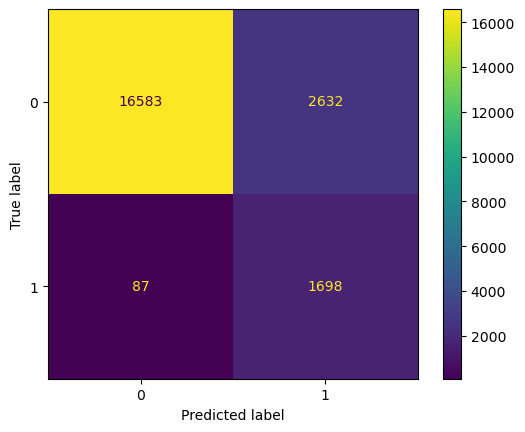

In [93]:
rf = RandomForestClassifier(
    n_estimators=52,
    min_samples_split=10,
    max_features=7,
    max_depth=6,
    class_weight={0: 1, 1: 13},
    random_state=32,
    n_jobs=1
)

# HistGradientBoosting (Twój najlepszy)
gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=6,
    max_leaf_nodes=10,
    max_iter=500,
    random_state=32,
    l2_regularization=0.1
)

# Logistic Regression (bez skalowania)
logreg = LogisticRegression(
    class_weight={0: 1, 1: 13},
    max_iter=1000,
    solver='liblinear',
    random_state=32
)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('gboost', gboost),
        ('rf', rf),
        ('logreg', logreg)
    ],
    voting='soft',
    weights=[1,3, 1],
    n_jobs=1
)

# Fit and evaluate
pipeline_fit(voting_clf)
_ = scores_model(voting_clf)

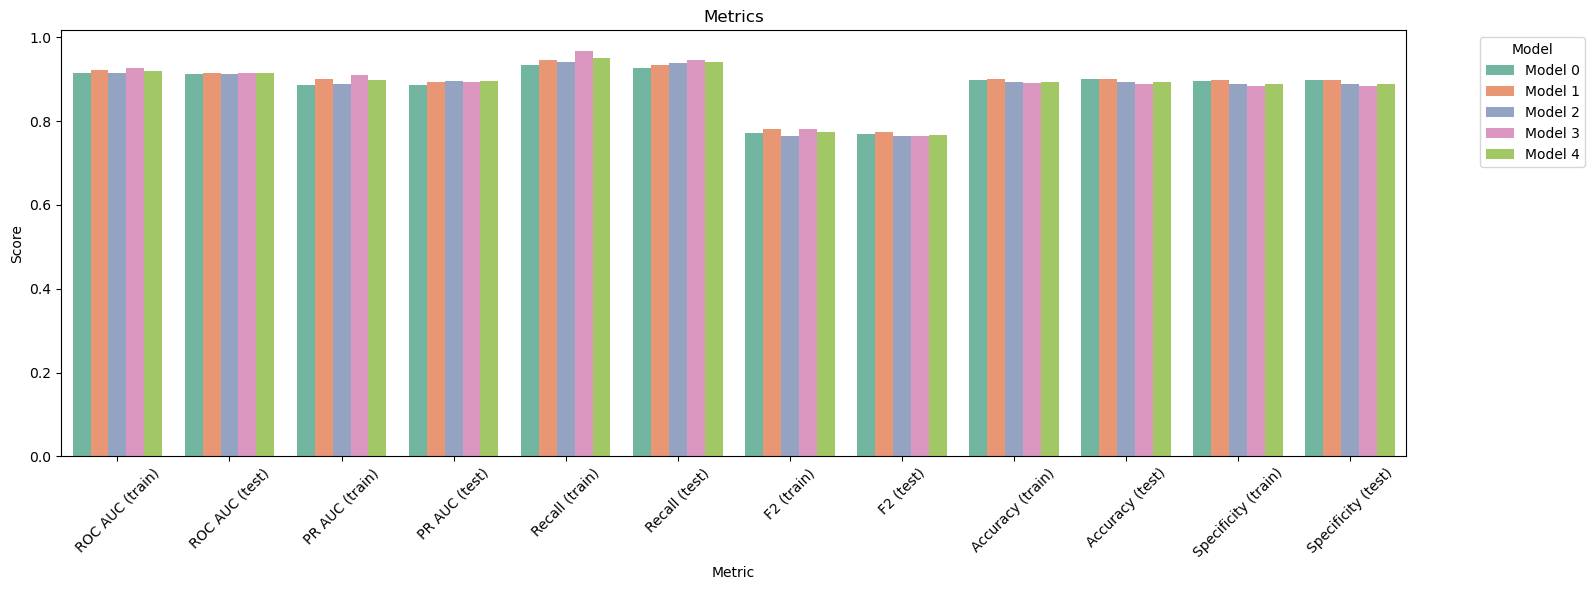

In [115]:
metrics = [
    'ROC AUC (train)', 'ROC AUC (test)',
    'PR AUC (train)', 'PR AUC (test)',
    'Recall (train)', 'Recall (test)',
    'F2 (train)', 'F2 (test)',
    'Accuracy (train)', 'Accuracy (test)',
    'Specificity (train)', 'Specificity (test)'
]

all_results = [g0, g1, g2, g3, g4]

df = pd.DataFrame(all_results, columns=metrics, index=[f'Model {i}' for i in range(len(all_results))])

df_long = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_long.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(16, 6))
sns.barplot(data=df_long, x='Metric', y='Value', hue='Model', palette='Set2')
plt.title('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()